In [2]:
import sys
sys.path.insert(0, '/home/ejafari/alignment/Git/src/')
from utils import *
from AIscEA import *
from evals import *
from rmCls import *
from similarity import *
from collections import Counter
from sklearn.metrics import silhouette_samples, silhouette_score

import warnings
warnings.filterwarnings('ignore')

# AIscEA

AnnData object with n_obs × n_vars = 33160 × 10309
AnnData object with n_obs × n_vars = 10309 × 33160
10309
33160
AnnData object with n_obs × n_vars = 10309 × 25403
    obs: 'n_genes'
    var: 'n_cells'
10309
25403
View of AnnData object with n_obs × n_vars = 10309 × 25403
    obs: 'n_genes'
    var: 'n_cells'


Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 10309 × 4301
    obs: 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


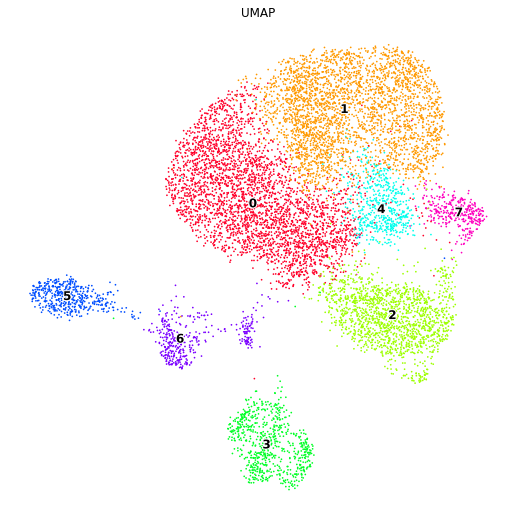

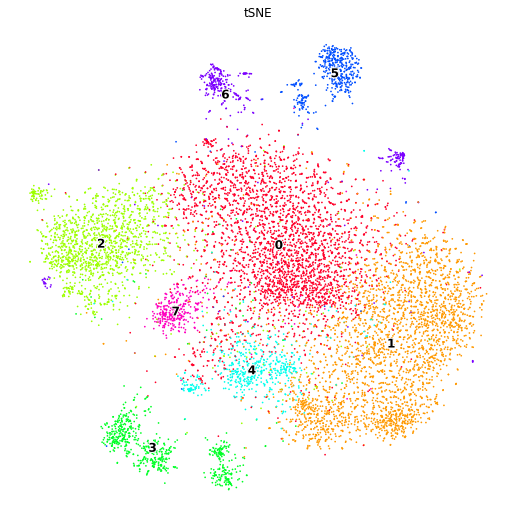

0 : 3289
1 : 2986
2 : 1545
3 : 699
4 : 573
5 : 475
6 : 408
7 : 334
AnnData object with n_obs × n_vars = 14 × 10309
AnnData object with n_obs × n_vars = 10309 × 14


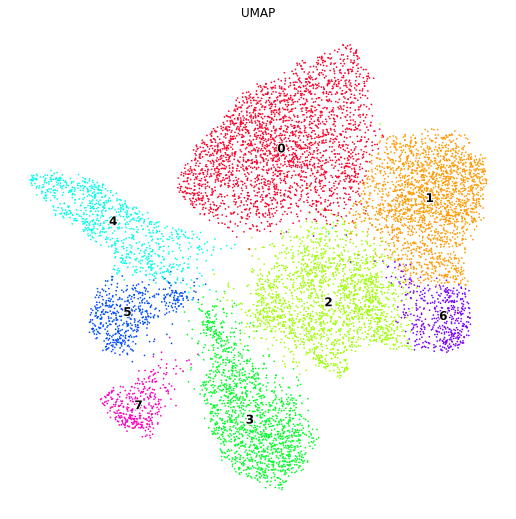

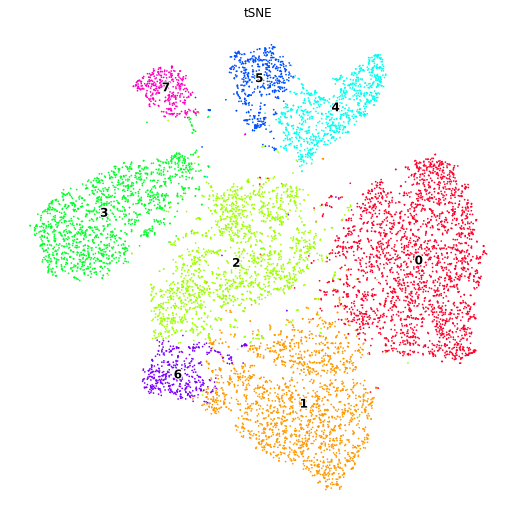

0 : 2610
1 : 2045
2 : 1894
3 : 1540
4 : 872
5 : 536
6 : 454
7 : 358
silhouette_avg:  0.36927515 0.4058516
(9901, 4301) (9773, 19932)
9373
   res1  cls_r_raw  cls_r     sil_r  res2  cls_a_raw  cls_a     sil_a  \
0   0.3        8.0    7.0  0.369275   0.4        8.0    7.0  0.405852   

   len(RNA)  len(ATAC)  Overlap  
0    9901.0     9773.0   9373.0  
1147 521
131023 19932
0 0
1 1
2 3
3 7
4 2
5 4
7 6
Line 166. >>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 3039.7141518592834
lambda, lev, n_neigh, n_iter, FOSCTTM1, FOSCTTM2:  0.8 2 3 0 0.22014437455738367 0.23290034132657003
9373.0 9373.0
9373 9373
Final FOSCTTM XonY and YonX:  0.22014437455738367 0.23290034132657003


In [3]:



res_df = pd.DataFrame(columns=['res1', 'cls_r_raw', 'cls_r', 'sil_r', 'res2', 'cls_a_raw', 'cls_a', 'sil_a', 'len(RNA)', 'len(ATAC)', 'Overlap'])
for res1 in [0.3]:
    for res2 in [0.4]:


        ############################ High_var = True ######################################
        input_dir = "/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/10k/"
        # Find marker genes of scRNAseq data
        markers_rna, rna = scRNAseq_clustering_original(input_dir + 'scRNAseq.csv', filtering=True, resl=res1, highly_var=True, tr=True, n_pc=15)


        cls_r_raw = len(set(rna.obs['leiden']))
        
        # Find clusters of low dimensional cisTopic result for scATACseq
        atac = clustering(input_dir + 'cisTopic_topics.tsv', transpose=True, resl=res2)


        ############################ scATAC ######################################
        # 1) Put cisTopic clusters and embedding values on the original data and 2) find marker genes and their logFC
        f_original = 'pred_matrix_closest_genes_1k_downstream_strand_first_prom.csv'
        markers_atac, atac_cis_on_org = process_cisTopic_on_orig(atac, f_original, input_dir, save=False, transpose=True)

        # To match name of the cells in RNA and ATAC data
        atac_cis_on_org.obs.index = [ind[1:] for ind in atac_cis_on_org.obs.index]
        atac.obs.index = [ind[1:] for ind in atac.obs.index]


        cls_a_raw = len(set(atac_cis_on_org.obs['leiden']))
        
        
        silhouette_avg_r = silhouette_score(rna.obsm['X_umap'], rna.obs['leiden'])
        silhouette_avg_a = silhouette_score(atac_cis_on_org.obsm['X_umap'], atac_cis_on_org.obs['leiden'])

        print("silhouette_avg: ", silhouette_avg_r, silhouette_avg_a)


        rna, atac_cis_on_org,  markers_rna, markers_atac = rm_tiny_cluster(rna, atac_cis_on_org,markers_rna, markers_atac, min_cells=200, rm_correspondence=False)

        col_ind, rna, atac_cis_on_org = extract_mapped_clusters(rna, markers_rna, atac_cis_on_org, markers_atac, p_val_count=6)

        try:
            print(rna.shape, atac_cis_on_org.shape)
            overlap = len(set(rna.obs.index) & set(atac_cis_on_org.obs.index))
            print(overlap)

            res_df.loc[len(res_df)] = [res1, cls_r_raw, len(set(rna.obs['leiden'])), silhouette_avg_r, res2, cls_a_raw, len(set(atac_cis_on_org.obs['leiden'])), silhouette_avg_a, rna.shape[0], atac_cis_on_org.shape[0], overlap]
        except:
            res_df.loc[len(res_df)] = [res1, res2,  None, None, None, None, None, None, None, None, 0]
            
            
        res_df.to_csv('10k_loop_params.csv', index=True)
        

print(res_df)

# aligns_dict = AIscEA(col_ind, rna, markers_rna, atac_cis_on_org, markers_atac)
aligns_dict, fracs1_all, fracs2_all = AIscEA(col_ind, rna, markers_rna, atac_cis_on_org, markers_atac)   

In [5]:
##### Double check the true mappings using cell labels

df_cells_common = pd.DataFrame()

for cls_rna in sorted(set(rna.obs['leiden'])):
    for cls_atac in sorted(set(atac_cis_on_org.obs['leiden'])):
        cells_atac  = atac_cis_on_org.obs[atac_cis_on_org.obs['leiden'] == str(cls_atac)].index
        cells_rna = rna.obs[rna.obs['leiden'] == str(cls_rna)].index
        df_cells_common.loc[('r_' + str(cls_rna)), ('a_' + str(cls_atac))] = len(set(cells_atac) & set(cells_rna))
        
df_cells_common






,a_0,a_1,a_2,a_3,a_4,a_6,a_7
r_0,2346.0,204.0,520.0,69.0,54.0,29.0,44.0
r_1,155.0,1759.0,630.0,8.0,4.0,420.0,8.0
r_2,17.0,13.0,136.0,1365.0,2.0,1.0,10.0
r_3,19.0,16.0,31.0,21.0,113.0,1.0,2.0
r_4,23.0,25.0,508.0,14.0,0.0,1.0,1.0
r_5,18.0,15.0,24.0,21.0,391.0,1.0,2.0
r_7,4.0,3.0,23.0,12.0,0.0,1.0,289.0


In [ ]:
##### Double check the true mappings using cell labels

df_cells_common = pd.DataFrame()

for cls_rna in sorted(set(rna.obs['leiden'])):
    for cls_atac in sorted(set(atac_cis_on_org.obs['leiden'])):
        cells_atac  = atac_cis_on_org.obs[atac_cis_on_org.obs['leiden'] == str(cls_atac)].index
        cells_rna = rna.obs[rna.obs['leiden'] == str(cls_rna)].index
        df_cells_common.loc[('r_' + str(cls_rna)), ('a_' + str(cls_atac))] = len(set(cells_atac) & set(cells_rna))
        
df_cells_common







# Umap plots

AnnData object with n_obs × n_vars = 33160 × 10309
AnnData object with n_obs × n_vars = 10309 × 33160
10309
33160
AnnData object with n_obs × n_vars = 10309 × 25403
    obs: 'n_genes'
    var: 'n_cells'
10309
25403
View of AnnData object with n_obs × n_vars = 10309 × 25403
    obs: 'n_genes'
    var: 'n_cells'


Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 10309 × 4301
    obs: 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


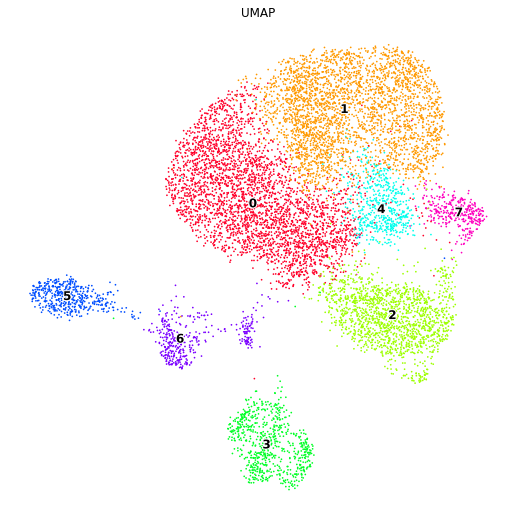

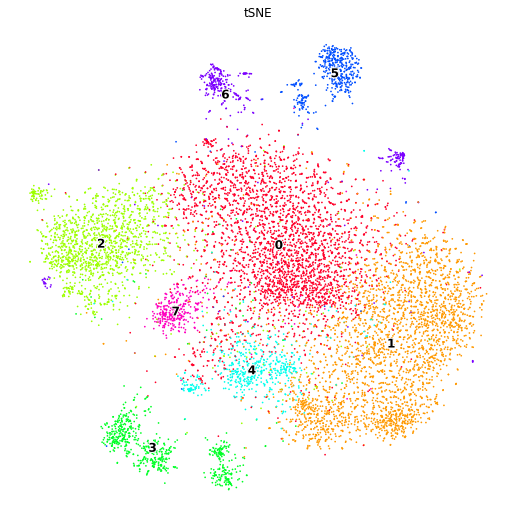

0 : 3289
1 : 2986
2 : 1545
3 : 699
4 : 573
5 : 475
6 : 408
7 : 334
AnnData object with n_obs × n_vars = 14 × 10309
AnnData object with n_obs × n_vars = 10309 × 14


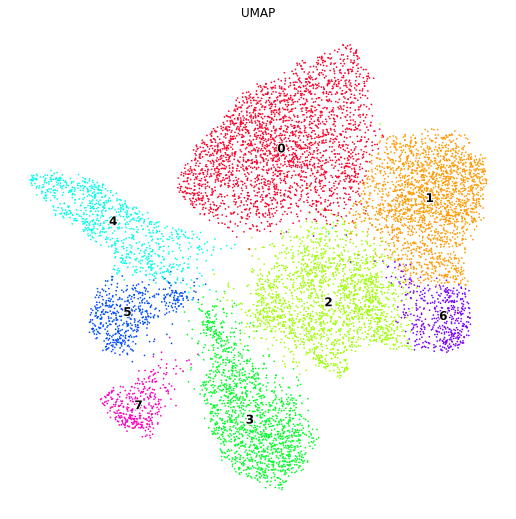

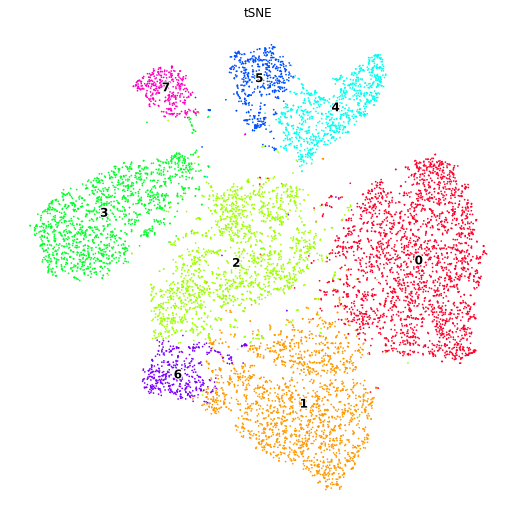

0 : 2610
1 : 2045
2 : 1894
3 : 1540
4 : 872
5 : 536
6 : 454
7 : 358


In [4]:
for res1 in [0.3]:
    for res2 in [0.4]:
#         for n_pcs in [0]:
#             for hvg in [True]:


        ############################ High_var = True ######################################
        input_dir = "/home/ejafari/alignment/downstream/data/SNAREseq/Mouse/10k/"
        # Find marker genes of scRNAseq data
        markers_rna, rna = scRNAseq_clustering_original(input_dir + 'scRNAseq.csv', filtering=True, resl=res1, highly_var=True, tr=True, n_pc=15)


        cls_r_raw = len(set(rna.obs['leiden']))
        
        # Find clusters of low dimensional cisTopic result for scATACseq
        atac = clustering(input_dir + 'cisTopic_topics.tsv', transpose=True, resl=res2)


        ############################ scATAC ######################################
        # 1) Put cisTopic clusters and embedding values on the original data and 2) find marker genes and their logFC
        f_original = 'pred_matrix_closest_genes_1k_downstream_strand_first_prom.csv'
        markers_atac, atac_cis_on_org = process_cisTopic_on_orig(atac, f_original, input_dir, save=False, transpose=True)

        # To match name of the cells in RNA and ATAC data
        atac_cis_on_org.obs.index = [ind[1:] for ind in atac_cis_on_org.obs.index]
        atac.obs.index = [ind[1:] for ind in atac.obs.index]

In [6]:
col_ind = {0: 0, 1: 1, 2: 3, 3: 7, 4: 2, 5: 4, 7: 6}
cats_rna = [int(i) for i in rna.obs['leiden'].cat.categories]
cats_atac = [int(i) for i in atac_cis_on_org.obs['leiden'].cat.categories]

for i in range(8):
    print(rna.uns['leiden_colors'][cats_rna.index(i)], atac.uns['leiden_colors'][cats_atac.index(i)])






#ff0029 #ff0029
#ff9900 #ff9900
#9dff00 #9dff00
#00ff26 #00ff26
#00ffed #00ffed
#004eff #004eff
#7b00ff #7b00ff
#ff00bf #ff00bf


In [41]:
colors = ["#ff0029", "#ff9900", "#ffff00", "#ff00bf", "#00ffed", "#0018ff", "#ff00bf", "#A020F0"]



0 #ff0029
1 #ff9900
2 #00ffed
3 #ffff00
4 #0018ff
5 5
6 #A020F0
7 #ff00bf


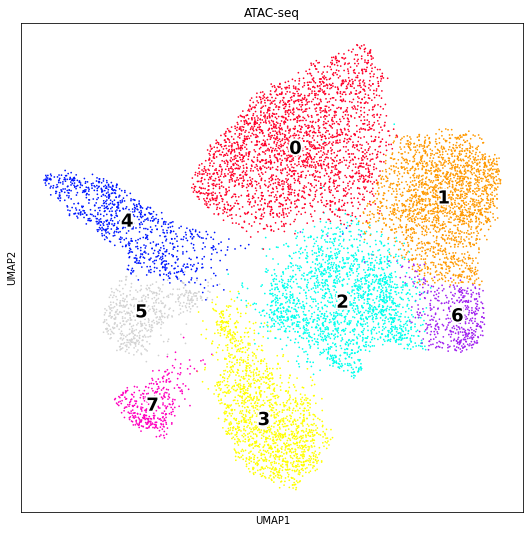

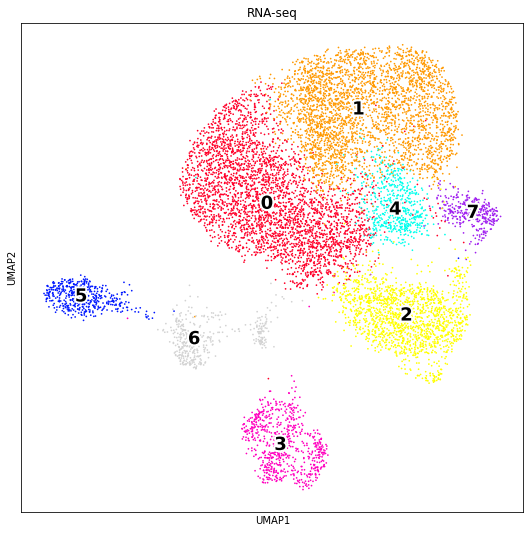

In [42]:
for cls in range(len(rna.uns['leiden_colors'])):
    if cls not in col_ind.keys():
        rna.uns['leiden_colors'][cats_rna.index(cls)] = '#D3D3D3' # Light grey

atac_cis_on_org.uns['leiden_colors'] = atac.uns['leiden_colors'] 


for cls in range(len(atac_cis_on_org.uns['leiden_colors'])):
    if cls not in col_ind.values():
        atac_cis_on_org.uns['leiden_colors'][cats_atac.index(cls)] = '#D3D3D3' # Light grey
        print(cls, cats_atac.index(cls))
    else:
        print(cls, atac_cis_on_org.uns['leiden_colors'][cats_atac.index(cls)])
        for cls_r, cls_a in col_ind.items():
            atac_cis_on_org.uns['leiden_colors'][cats_atac.index(cls_a)] = colors[cls_r]
            rna.uns['leiden_colors'][cats_rna.index(cls_r)] = colors[cls_r]

sc.pl.umap(atac_cis_on_org, color=['leiden'], legend_loc='on data', legend_fontsize=18, legend_fontoutline=4,frameon=True, title='ATAC-seq', save='Mus_10k_ATAC_grey.svg')#
sc.pl.umap(rna, color=['leiden'], legend_loc='on data', legend_fontsize=18, legend_fontoutline=4,frameon=True, title='RNA-seq', save='Mus_10k_RNA_grey.svg')#